In [1]:
import os
import numpy as np
import torch
from PIL import Image

from house import House
import copy
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import transforms as T
from engine import train_one_epoch, evaluate
import utils
import matplotlib.pyplot as plt

from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, discrete_cmap
discrete_cmap()


In [2]:
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
rooms = ["Outdoor", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
room_ids = [1,3,4,5,6,7,8,9,10,11]
room_labels = {rooms[i]:i+1 for i in range(len(rooms))}

In [3]:
import cv2
class CubicasaDataset(object):
    def __init__(self, root, mode, transforms=None):
        self.root = root
        #self.dict = torch.load(f"data/cubicasa5k/instance_info_{mode}.pt")
        self.transforms = transforms
        self.imgs = np.genfromtxt(root + '/'+mode+'.txt', dtype='str')
    
        
    def __getitem__(self, idx):
        # load images ad masks
        
        #instance_info = self.dict[self.imgs[idx]]
        
        # fplan = cv2.imread(self.root + self.imgs[idx]+'F1_original.png')
        # img = cv2.cvtColor(fplan, cv2.COLOR_BGR2RGB)/255.  # correct color channels

        org_img_path = self.root + self.imgs[idx]+'F1_original.png'
        img_path = self.root + self.imgs[idx]+'F1_scaled.png'
        svg_path = self.root + self.imgs[idx]+'model.svg'

        img = Image.open(org_img_path).convert("RGB")

        height, width, _ = cv2.imread(img_path).shape
        height_org, width_org, _ = cv2.imread(org_img_path).shape

        # Getting labels for segmentation and heatmaps
        house = House(svg_path, height, width)
        # Combining them to one numpy tensor
        label = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

        label = label.unsqueeze(0)
        label = torch.nn.functional.interpolate(label,
                                                    size=(height_org, width_org),
                                                    mode='nearest')
        label = label.squeeze(0)[0]


        #############process items##############
        masks = label.data.numpy()
      
        boxes = []
        labels = []
        num_obj = 0
        
        mask_tensor = []
        areas = []

        limit_list = []

        for r in room_ids:
            x = copy.copy(masks)
            x[masks != r] = 0 
            x = x.astype(np.uint8)
            contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            limit_list +=[(r, cot) for cot in contours]
            num_obj+=len(contours)
        
        if num_obj >20:
            rand_inds = np.random.choice(np.arange(num_obj), 20, replace  = False)
        elif num_obj == 0:
            rand_inds = []
            print('No objects in this image, folder:', self.imgs[idx])
        else:
            rand_inds = np.arange(num_obj)
        
        for ind in rand_inds:
            r, tcnt = limit_list[ind]
            im = np.zeros((height,width,3), np.uint8)
            im = cv2.drawContours(im, [tcnt], -1, (255,255,255), -1)
            mask_tensor.append((im[:,:,0]/255).astype(np.int8))
            areas.append(cv2.contourArea(tcnt,False))
            x,y,w,h = cv2.boundingRect(tcnt)
            boxes.append([x,y,x+w,y+h])
            labels.append(room_labels[room_classes[r]])
        
        boxes = torch.FloatTensor(boxes)
        labels = torch.as_tensor(labels, dtype = torch.long)
        areas = torch.FloatTensor(areas)
        
        
        try:
            mask_tensor = np.stack(mask_tensor, 0)
        except:
            mask_tensor = np.array([])


        #######################################
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = torch.as_tensor(mask_tensor, dtype=torch.uint8)
        target["image_id"] = torch.tensor([idx], dtype = torch.int8)
        target["area"] = areas
        target["iscrowd"] = torch.zeros(num_obj, dtype = torch.int8)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)



In [4]:


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 1+10
# use our dataset and defined transformations
dataset = CubicasaDataset('data/cubicasa5k', 'train',get_transform(train=True))

dataset_test = CubicasaDataset('data/cubicasa5k', 'val',get_transform(train=False))

# split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=False, 
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, 
        collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)


    

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

# check models

In [6]:
model.load_state_dict(torch.load('models/maskrcnn_0.pt',map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
from collections import defaultdict
class Decode_Maskrcnn(object):
    
    def __init__(self, dataset, idx, model = None, prediction = None):
        
        self.folder = dataset.imgs[idx]
        self.img = dataset[idx][0]
        
        if not prediction:
            model.eval()
            with torch.no_grad():
                self.pred = model([self.img])[0]
        else:
            self.pred = prediction[0]
    
    
    ##################GROUND TRUTH####################
    
    def get_groundtruth(self, img_show = True):
    
        
        svg_path ='./data/cubicasa5k'+self.folder+'model.svg'
        img_path ='./data/cubicasa5k'+self.folder+'F1_scaled.png'
        org_img_path ='./data/cubicasa5k'+self.folder+'F1_original.png'
        height, width, _ = cv2.imread(img_path).shape
        height_org, width_org, _ = cv2.imread(org_img_path).shape

        house = House(svg_path, height, width)
        # Combining them to one numpy tensor
        gt = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

        gt = gt.unsqueeze(0)
        gt = torch.nn.functional.interpolate(gt,size=(height_org, width_org),
                                                            mode='nearest')
        gt = gt.squeeze(0)[0]

        if img_show:
            plt.figure(figsize=(10,10))
            ax = plt.subplot(1, 1, 1)
            plt.title('Ground Truth Rooms and walls', fontsize=20)
            ax.axis('off')
            n_rooms = 12
            rseg = ax.imshow(gt, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
            cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
            cbar.ax.set_yticklabels(room_classes, fontsize=20)
            plt.show()
        
        return gt
    
    
    ##################PREDICTION#######################
    
    
    #segmentation map
    def get_segmap(self, img_show = True):
        
        num,_, H,W =self.pred['masks'].shape

        seg_map = torch.zeros((H,W))
        labels = set()
        for i in range(num):
            label = int(self.pred['labels'][i].data.numpy())
            if label>=2:
                label+=1
            if label in labels:
                continue
            mask = self.pred['masks'][i,0,:,:]

            seg_map[mask>0.1] = label

            labels.add(label)
        
        if img_show:
            plt.figure(figsize=(10,10))
            ax = plt.subplot(1, 1, 1)
            plt.title('Predicted Rooms and walls', fontsize=20)
            ax.axis('off')
            n_rooms = 12
            rseg = ax.imshow(seg_map, cmap = 'rooms', vmin=0, vmax=n_rooms-0.1)
            cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms)+0.3, fraction=0.046, pad=0.01)
            cbar.ax.set_yticklabels(room_classes, fontsize=20)
            plt.show()

        return seg_map

    
    
    #room detection 
    def room_detect(self, class_id, img_show = True):
        
        self.results = {}

        for i in range(1,11):
            self.results[i] = defaultdict(list)

        for i,lab in enumerate(self.pred['labels']):
            lab = int(lab.data.numpy())
            self.results[lab]['boxes'].append(self.pred['boxes'][i])
        
        im = self.img.data.numpy().copy()
        im = np.moveaxis(im, 0,-1)
        image = im
        
        if len(self.results[class_id]['boxes'])!= 0:
        
            for (x,y,z,w) in self.results[class_id]['boxes']:

                image = cv2.rectangle(image, (x,y), (z,w), (0,252,0), 3) 
                #image = cv2.putText(image, rooms[class_id-1], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)

            result = cv2.UMat.get(image)

            if img_show:
                plt.figure(figsize = (20,12))
                plt.imshow(result)
                plt.title(rooms[class_id-1])
        
        else:
            print('No such object')
            result = None
        
        return result
    
    
    def collect_result(self, img_show = True):
    
        
        seg_map = self.get_segmap(img_show =False).data.numpy()
        
        result = self.img.data.numpy().copy()
        result = np.moveaxis(result, 0,-1)
        
        for i in range(1,11):
            
            pix = i+1 if i>=2 else i
            m = copy.copy(seg_map)
            m[seg_map!= pix] = 0 
            m = m.astype(np.uint8)

            contours, _ = cv2.findContours(m,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            for tcnt in contours: 

                x,y,w,h = cv2.boundingRect(tcnt)
                result = cv2.rectangle(result, (x,y), (x+w,y+h), (0,252,0), 3) 
            result = cv2.putText(result, rooms[i-1], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (252,0,0), 2)

        
        result = cv2.UMat.get(result)
        if img_show:
            plt.figure(figsize = (20,12))
            plt.imshow(result)
            plt.title('Predict Result collection')


        return result

    

In [10]:
dm = Decode_Maskrcnn(dataset_test, 0, model)

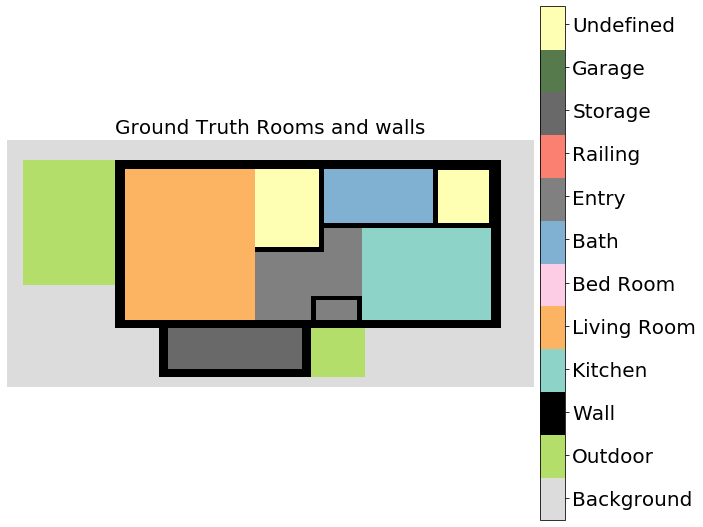

In [11]:
gt = dm.get_groundtruth()

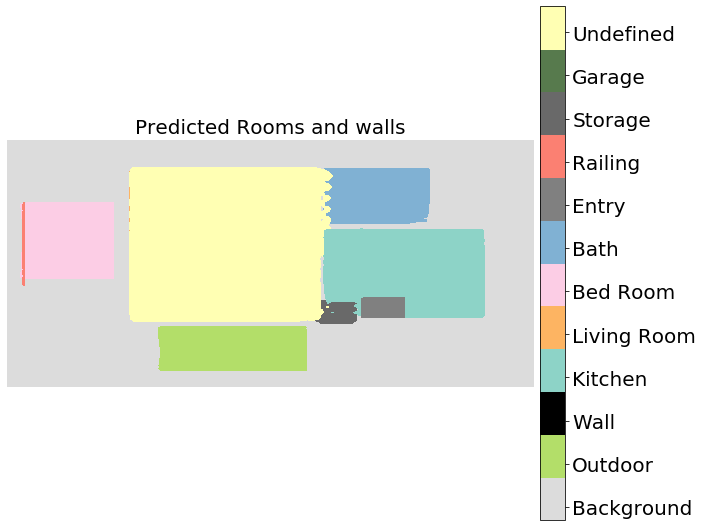

In [12]:
seg_map =  dm.get_segmap()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


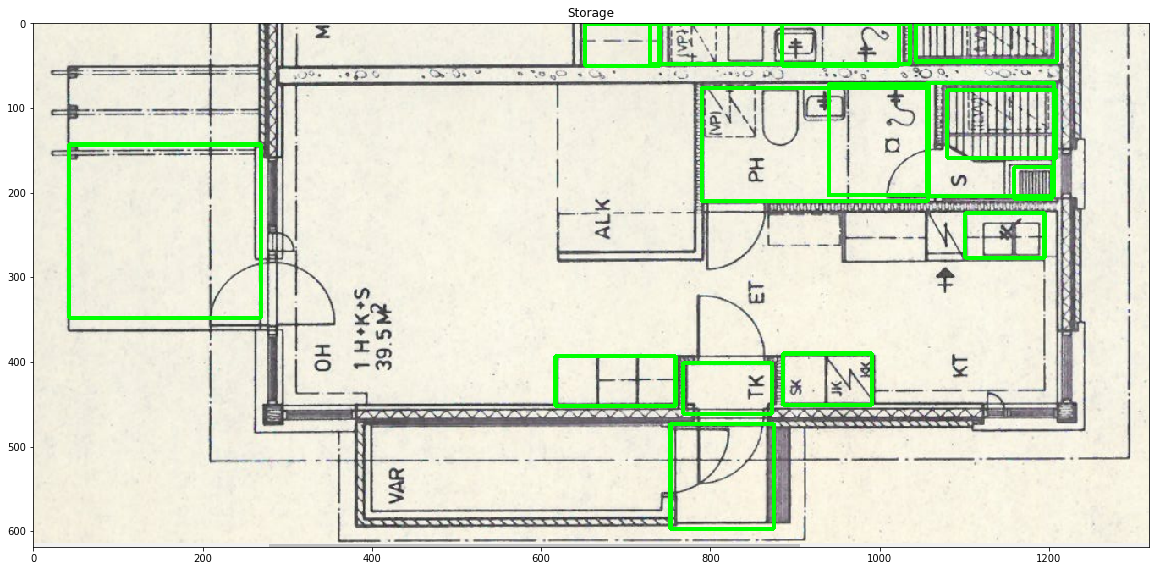

In [13]:
bed_room =  dm.room_detect(room_labels['Storage'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


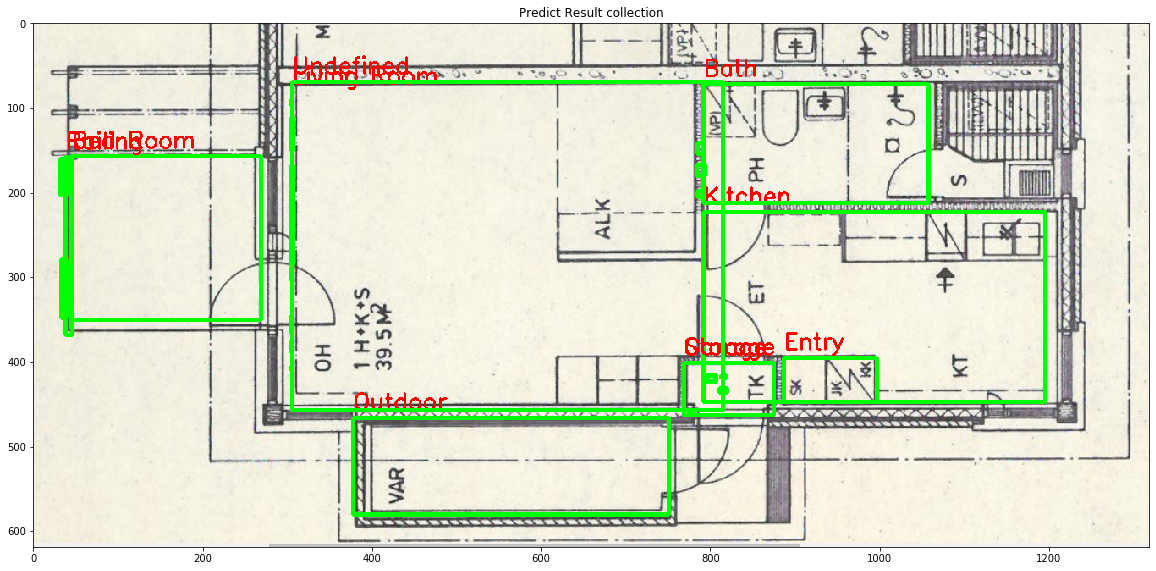

In [15]:
dm = Decode_Maskrcnn(dataset_test, 0, model)
rc = dm.collect_result()